# background: 
**imagine that you have some pneumonia data that has helped you train a model and a client (who needs to know if his patients have pneumonia) asks you for your model to make predictions, as both parties want to maintain their privacy , you must encrypt your model and your client will encrypt his data**

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

In [0]:
# Imports here
import pandas as pd
import torch
import numpy as np
import os
import torchvision
from torchvision import datasets, transforms, models
import time
import copy
import torch.nn.functional as F
import seaborn as sns
from PIL import Image
from collections import OrderedDict

from torch import nn, optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt

%matplotlib inline

In [0]:
data_dir = "/content/gdrive/My Drive/neumonia/chest_xray/"
train_dir = data_dir + '/train'
test_dir = data_dir + '/test'
# TODO: Define your transforms for the training and validation sets
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(240),
        transforms.RandomResizedCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(240),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ])
    }

# TODO: Load the datasets with ImageFolder

dirs = {'train': train_dir, 
        'test': test_dir}

datasets = {x: torchvision.datasets.ImageFolder(dirs[x],   transform=data_transforms[x]) for x in ['train', 'test']}

# TODO: Using the image datasets and the trainforms, define the dataloaders

dataloaders = {x: torch.utils.data.DataLoader(datasets[x], batch_size=32, shuffle=True, num_workers=2) for x in ['train', 'test']}

dataset_sizes = {x: len(datasets[x]) 
                              for x in ['train', 'test']}
print(dataset_sizes)

In [0]:
_ = datasets['test'].class_to_idx
cat_to_name = {_[i]: i for i in list(_.keys())}
cat_to_name

In [0]:
%%time

x, y = next(iter(dataloaders['train']));

CPU times: user 9.47 ms, sys: 15.8 ms, total: 25.2 ms
Wall time: 30.5 s


In [0]:
class_names = datasets['train'].classes
print(class_names)

In [0]:
def train_model(model, criteria, optimizer, scheduler = None, epochs=50, device='cuda'):

    since = time.time()
    best_model = copy.deepcopy(model.state_dict())
    
    # initialize tracker for accuracy 
    best_acc = 0 
    TS_loss = pd.DataFrame(np.nan, index = range(1,epochs+1), columns = ['train loss','test loss'])
    TS_acc = pd.DataFrame(np.nan,index = range(1,epochs+1), columns = ['train acc','test acc'])
    
    for epoch in range(1,epochs+1):
        print('Epoch {}/{}'.format(epoch, epochs))
        print('-' * 10)
        
        # monitor loss/accuracy
        train_loss_running = 0.0
        test_loss_running = 0.0
        train_acc_running = 0.0
        test_acc_running = 0.0

        ###################
        # train the model #
        ###################
        if scheduler:
            scheduler.step()
        model.train() # prep model for training
        
        for data, target in dataloaders['train']:
    
            # Move input and data tensors to the default device
            data, target = data.to(device), target.to(device)
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criteria(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss 
            train_loss_running += loss.item()*data.size(0)
            # accuracy
            _, preds = torch.max(output, 1)
            train_acc_running  += torch.sum(preds == target.data)
            
            del loss

        ######################    
        # test the model #
        ######################
        model.eval()
        with torch.no_grad():
            for data, target in dataloaders['test']:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criteria(output, target)
                test_loss_running += loss.item()*data.size(0)
                
                _, preds = torch.max(output, 1)
                test_acc_running  += torch.sum(preds == target.data)
                
                del loss


        # statistics
        train_loss = train_loss_running/ dataset_sizes['train']
        test_loss = test_loss_running/ dataset_sizes['test']
        train_acc = train_acc_running.double()/ dataset_sizes['train']
        test_acc = test_acc_running.double()/ dataset_sizes['test']
        
        TS_loss.loc[epoch] = [train_loss, test_loss]
        TS_acc.loc[epoch] = [(train_acc.cpu().numpy()), (test_acc.cpu().numpy())]                                         

        # print training/test statistics 
        print('Train - Loss: {:.4f} Acc: {:.4f}'.format(train_loss, train_acc))
        print('test - Loss: {:.4f} Acc: {:.4f}'.format(test_loss, test_acc))                                                 
                                                             
        # save model if test acc has increased
        if test_acc > best_acc:
            print('Validation Acc increased ({:.4f} --> {:.4f}).  Saving model.'.format(best_acc,test_acc))
            best_model = copy.deepcopy(model.state_dict())                                                                    
            best_acc = test_acc
        
        print()
    
    #End
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best test Acc: {:4f}'.format(best_acc))
                                                   
    TS_loss.plot(title = 'loss')
    TS_acc.plot(title = 'acc')
                                                   
    # load best model weights
    model.load_state_dict(best_model)
    torch.save(model.state_dict(), 'other_train.pt')
    model.to("cpu")
    
    return model

In [0]:
def test(model, dataloader, criteria, device):
    loss = 0
    accuracy = 0
    with torch.no_grad():
        for images, labels in iter(dataloader):
            
            images, labels = images.to(device), labels.to(device) # Move input and label tensors to the GPU
            
            output = model.forward(images)
            loss += criteria(output, labels).item()

            ps = torch.exp(output) # get the class probabilities from log-softmax
            equality = (labels.data == ps.max(dim=1)[1])
            accuracy += equality.type(torch.FloatTensor).mean()
    
    return loss, accuracy

In [0]:
len(class_names)

2

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [0]:
model= models.densenet161(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/checkpoints/densenet161-8d451a50.pth
100%|██████████| 115730790/115730790 [00:04<00:00, 25095003.36it/s]


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inpla

Epoch 1/2
----------
Train - Loss: 0.6018 Acc: 0.7811
test - Loss: 0.7326 Acc: 0.7051
Validation Acc increased (0.0000 --> 0.7051).  Saving model.

Epoch 2/2
----------
Train - Loss: 0.4375 Acc: 0.8161
test - Loss: 0.6973 Acc: 0.7228
Validation Acc increased (0.7051 --> 0.7228).  Saving model.

Training complete in 27m 55s
Best test Acc: 0.722756


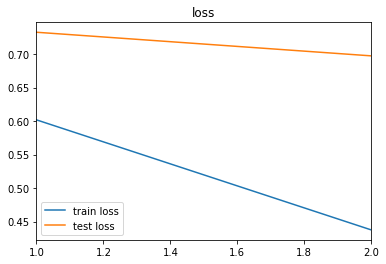

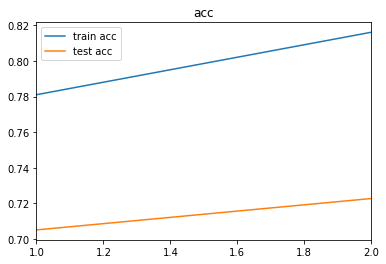

In [0]:

model.fc =  nn.Sequential(
         nn.Linear(2208, 1056),
         nn.ReLU(),
         nn.Linear(1056, len(class_names)))
epochs = 2

criteria = nn.CrossEntropyLoss()    
    
optimizer = optim.Adam(model.parameters(), lr=1e-2)


scheduler = lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

model.to(device)

model_tocpu = train_model(model, criteria, optimizer, scheduler, epochs,device)

In [0]:
#save and load model
def save_model_checkpoint(model, optimizer, criteria, epochs):
  model.to('cpu')
  model.class_to_idx = datasets['train'].class_to_idx
  checkpoint = {'input_size': 224*224*3,
                'output_size': 2,
                'model': model,
                'state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'criterion': criteria,
                'epochs': epochs,
                'class_to_idx': model.class_to_idx}

  path = "/content/gdrive/My Drive/pneumoni.pth"
  torch.save(checkpoint,path)


# load model function 
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath, map_location='cpu')
    model = checkpoint["model"]
    model.load_state_dict(checkpoint['state_dict'])
    return model

In [0]:
#save_model_checkpoint(model_tocpu,optimizer,criteria,epochs)

In [0]:
model_loaded = load_checkpoint("/content/gdrive/My Drive/pneumoni.pth")


In [0]:
#
#STAR Encrypted Computation in PySyft
#Encrypted Deep Learning in PyTorch
!pip install syft

In [0]:

import syft as sy  

hook = sy.TorchHook(torch) 

client = sy.VirtualWorker(hook, id="client") 
bob = sy.VirtualWorker(hook, id="bob")
alice = sy.VirtualWorker(hook, id="alice")
crypto_provider = sy.VirtualWorker(hook, id="crypto_provider") 

In [0]:
#########################################################################################
#########################################################################################
#########################################################################################
#########################################################################################
#########################################################################################
#########################################################################################
#ENCRIPTED MODEL

In [0]:
for param in model_loaded.parameters():
    param.requires_grad = True
    

In [0]:
encrypted_model = model_loaded.fix_precision().share(alice, bob, crypto_provider=crypto_provider)


In [0]:
#########################################################################################
#########################################################################################
#########################################################################################
#########################################################################################
#########################################################################################
#########################################################################################
#THE CLIENT


In [0]:
data_dir = "/content/gdrive/My Drive/neumonia/chest_xray/"
val_dir = data_dir + '/val'

# TODO: Define your transforms for the training and validation sets
data_transforms = {
    
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ])
    }

# TODO: Load the datasets with ImageFolder


data_valset = torchvision.datasets.ImageFolder(val_dir,transform=data_transforms['valid'])

# TODO: Using the image datasets and the trainforms, define the dataloaders

dataloader_client = torch.utils.data.DataLoader(data_valset, batch_size=32, shuffle=True, num_workers=2)

dataset_sizes = len(data_valset)

print(dataset_sizes)

In [0]:
cat_to_name

In [0]:
private_val_loader = []
for data, target in dataloader_client: 
    data_private = data.share(alice, bob, crypto_provider=crypto_provider),
    target_private = target.share(alice, bob, crypto_provider=crypto_provider)
    private_val_loader.append(data_private,target_private)

In [0]:
list(private_val_loader)


In [0]:
def private_test(model_encripted, dataloader_encripted, criteria, device):
    loss = 0
    accuracy = 0
    with torch.no_grad():
        for images, labels in iter(dataloader_encripted):
            
            images, labels = images.to(device), labels.to(device) # Move input and label tensors to the GPU
            
            output = model_encripted.forward(images)
            loss += criteria(output, labels).item()

            ps = torch.exp(output) # get the class probabilities from log-softmax
            equality = (labels.data == ps.max(dim=1)[1])
            accuracy += equality.type(torch.FloatTensor).mean()
    
    return loss, accuracy

In [0]:
criteria = nn.CrossEntropyLoss()    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
encrypted_model.to(device)

In [0]:
private_test(encrypted_model,private_val_loader,criteria,device)

In [0]:
bob.objects()